In [1]:
import sys
sys.path.append('../')
from data.datasets import PureCompounds
from data.data_functions import DataLoader, DerivTransform, NormalizeTransform
from data.experiment_parameters import ExperimentFilter, Chamber, Sensor, InjectionTime, InjectionRate, InjectionVolume, DataFilter

In [2]:
chem_list = ['Pentane', 'Hexane','Heptane','Octane','Nonane','Decane','Toluene']
filters = ExperimentFilter(Chamber('tall'), Sensor('SM30_Sensor'), InjectionTime(15.0), InjectionRate(6.0), InjectionVolume(1.3))
exp_derivs, labels = DataLoader(PureCompounds(chem_list, filters=filters), transforms=[DerivTransform, NormalizeTransform]).load()

Loading experimental data
Pentane (1/7): [===================0] 100% complete
Hexane (2/7): [===================0] 100% complete
Heptane (3/7): [===================0] 100% complete
Octane (4/7): [===================0] 100% complete
Nonane (5/7): [===================0] 100% complete
Decane (6/7): [===================0] 100% complete
Toluene (7/7): [===================0] 100% complete
Length of experimental set loaded: 45


In [12]:
from data.experiment_parameters import _create_experiment_label_df, create_physical_property_label, create_concentration_label

physical_properties = create_physical_property_label(labels.keys(), 'Vapor Pressure', 'Boiling Point', 'Flash Point', 'Viscosity')
#create_concentration_label(labels.keys())

# Alkanes only

## Dataset split (train-test)

Perform a stratified train-test split based on the class labels

In [13]:
from sklearn.model_selection import train_test_split

alkane_labels = {k:v for k,v in labels.items() if v.lower()!='toluene'}

X_train, X_test, y_train, y_test = train_test_split(list(alkane_labels.keys()), list(alkane_labels.values()), test_size=0.2, shuffle=True, stratify=list(alkane_labels.values()))

## Model training

In [14]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate, GridSearchCV

### Gridsearch

Do on one property only

In [15]:
svm = SVR()

##### Coarse grid search

In [35]:
clf = svm.fit(X,y)
clf.score(X,y)

-0.2500773123814348

In [41]:
print(clf.predict(X[:2]), y[:2])

[6.19089581 5.22695024] [18.477418996839496, 0.4082808106380722]


In [32]:
param_grid = {'C': [pow(10,n) for n in range(-8, 9, 2)], 'kernel': ['linear']}

X = [exp_derivs[exp] for exp in X_train]
y = [physical_properties[exp].Vapor_Pressure for exp in X_train]

grid_search = GridSearchCV(svm, param_grid, scoring='accuracy', cv=5, return_train_score=True)
hpo_coarse_results = grid_search.fit(X, y)

/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/envs

In [ ]:
pd.DataFrame(hpo_coarse_results.cv_results_)[['param_C', 'mean_train_score', 'mean_test_score']].pivot_table(columns=['param_C'])

param_C,1.000000e-08,1.000000e-06,1.000000e-04,1.000000e-02,1.000000e+00,1.000000e+02,1.000000e+04,1.000000e+06,1.000000e+08
mean_test_score,0.166667,0.166667,0.166667,0.166667,0.366667,0.816667,0.85,0.85,0.85
mean_train_score,0.183333,0.183333,0.183333,0.183333,0.408333,0.970833,1.00,1.00,1.00


##### Fine grid search

In [ ]:
param_grid = {'C': [pow(10,n) for n in np.linspace(1,4,11)], 'kernel': ['linear']}

grid_search = GridSearchCV(svm, param_grid, scoring='accuracy', cv=5, return_train_score=True)
hpo_coarse_results = grid_search.fit([exp_derivs[exp] for exp in X_train], y_train)

/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [ ]:
pd.DataFrame(hpo_coarse_results.cv_results_)[['param_C', 'mean_train_score', 'mean_test_score']].pivot_table(columns=['param_C'])

param_C,10.000000,19.952623,39.810717,79.432823,158.489319,316.227766,630.957344,1258.925412,2511.886432,5011.872336,10000.000000
mean_test_score,0.733333,0.766667,0.750000,0.850000,0.816667,0.85,0.85,0.85,0.85,0.85,0.85
mean_train_score,0.808333,0.900000,0.954167,0.966667,0.987500,1.00,1.00,1.00,1.00,1.00,1.00


### Cross-validation/dev

In [ ]:
svm = SVR(C=300, kernel='linear')

In [ ]:
cv_results = cross_validate(svm, [exp_derivs[exp] for exp in X_train], y_train, scoring='accuracy', cv=5, return_train_score=True, return_estimator=True)
{key:cv_results[key] for key in cv_results if key != 'estimator'}

/Applications/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'fit_time': array([0.0034771 , 0.0014441 , 0.00178099, 0.00141501, 0.00142407]),
 'score_time': array([0.00067592, 0.00046587, 0.00067115, 0.00048494, 0.00045013]),
 'test_score': array([0.91666667, 0.91666667, 0.83333333, 0.75      , 0.83333333]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [ ]:
class Ens:
    def __init__(self, estimators):
        self.estimators = estimators
        self._estimator_type = 'classifier'
        
    def predict(self, X):
        final = []
        for x in X:
            predictions = []
            for est in self.estimators:
                predictions.append(est.predict([x])[0])
            final.append(max(set(predictions), key=predictions.count))
        return np.array(final)

In [ ]:
single = svm.fit([exp_derivs[exp] for exp in X_train], y_train)
ensemble = Ens(cv_results['estimator'])

### Metrics

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix

0.6875


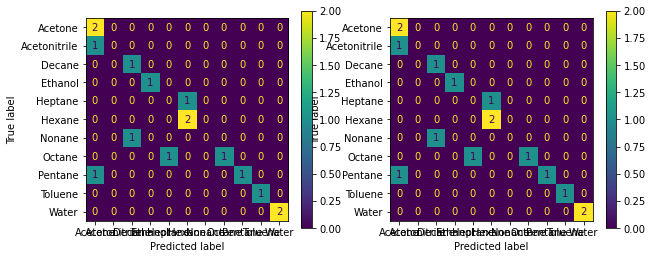

In [ ]:
_, ax = plt.subplots(1,2, figsize=(10,4))

print(single.score([exp_derivs[exp] for exp in X_test], y_test))

plt.plot(y_test, single.predict(X_test))
plt.plot(y_test, ensemble.predict(X_test))